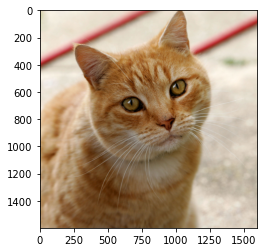

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

img = Image.open('./Cat03.jpg')

fig = plt.figure()
plt.imshow(img)

# resize to imagenet size 
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

patch_size = 16 # 16 pixels
pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape


class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))


patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes)) 

class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

# Split the picture into blocks

Vision transformer from Colab

website: https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb#scrollTo=J9lOBfezfPCX

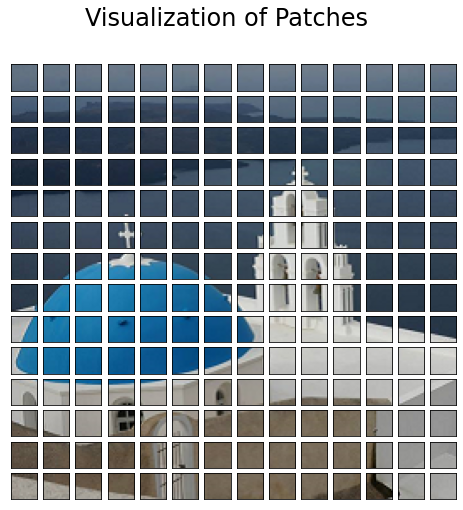

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model
#!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png

img = PIL.Image.open('santorini.png')

# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d 
# with stride=(16, 16) shown above.

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
# fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14  # modulo
    y = i // 14 # divide
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [13]:
x=100  % 14
y=100 // 14
print(x)
print(y)

2
7


In [16]:
import PIL
img = PIL.Image.open('santorini.png')
img = np.asarray(img)
print(img)

[[[ 98 114 130]
  [ 98 114 130]
  [ 98 114 130]
  ...
  [107 123 138]
  [107 123 138]
  [107 123 138]]

 [[ 98 114 130]
  [ 98 114 130]
  [ 95 111 127]
  ...
  [106 122 137]
  [106 122 137]
  [106 122 137]]

 [[ 98 114 130]
  [ 98 114 130]
  [ 96 112 128]
  ...
  [104 120 136]
  [105 121 136]
  [105 121 136]]

 ...

 [[150 143 135]
  [161 154 146]
  [163 156 148]
  ...
  [171 171 169]
  [169 169 167]
  [169 169 167]]

 [[157 150 142]
  [144 137 129]
  [156 149 141]
  ...
  [171 171 169]
  [171 171 169]
  [169 169 167]]

 [[155 148 140]
  [145 138 130]
  [159 152 144]
  ...
  [170 170 168]
  [173 173 171]
  [171 171 169]]]
